# Package Load

In [1]:
import preprocessing
import tensorflow as tf
import numpy as np
import random
import sys
import utils
import pickle
from IPython.display import Image
# preprocessing : 이미지 파일로 존재하는 데이터를 numpy와 onehotencoding 라벨로 바꿔주는 모듈
# tensorflow : 텐서플로우 , 일반적으로 tf로 줄여서 사용
# numpy : fundamental package for scientific computing with Python
# pickle : python 의 데이터 형식을 그대로 저장하기 위한 파이썬 기본 패키지

# Image Loading

In [2]:
# 이미지 파일이 있는 폴더를 parameter 로 입력
train_imgs , train_labs =preprocessing.get_imagenet_data("/home/mediwhale-3/imagenet",1000)


def next_batch(imgs , labs , batch_size):
    indices=random.sample(range(len(imgs)) , batch_size)
    batch_xs=imgs[indices]
    batch_ys=labs[indices]
    return batch_xs , batch_ys

# preprocessing 모듈에서 train_imgs , train_labs , test_imgs , test_labs 를 불러 온다.
# fully connected 모델을 위해 32x32x3 크기의 이미지를 3072 으로 reshape 한다.
# next_batch 함수는 batch_size 수 만큼 random 으로 추출하여 train batch 를 생성하는 함수

# Set Placeholder And Variables

In [3]:
height = 224
width = 224
color_ch=3
n_classes = 1000
learning_rate=0.001
max_iter=10000
check_point=100
x_ =tf.placeholder(tf.float32, [ None , height , width , color_ch ])
y_ =tf.placeholder( tf.int32 , [ None , n_classes ])

# Placeholder 는 차후에 입력할 값
# Variables 는 weight 로 학습시 변하는 값

# Network Modeling

In [4]:
# layer 1

w1 = tf.get_variable("filter_w1" , [7,7,3,64] , initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.conv2d(x_ , w1 , [1,2,2,1],"VALID")
layer1 = tf.nn.relu(layer1)

layer1 = tf.nn.max_pool(layer1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
layer1 = tf.nn.local_response_normalization(layer1)

w2 = tf.get_variable("filter_w2" , [1,1,64,64] , initializer=tf.contrib.layers.xavier_initializer())
layer2 = tf.nn.conv2d(layer1 , w2 , [1,1,1,1],"VALID")
layer2 = tf.nn.relu(layer2)

w3 = tf.get_variable("filter_w3" , [3,3,64,192] , initializer=tf.contrib.layers.xavier_initializer())
layer3 = tf.nn.conv2d(layer2 , w3 , [1,1,1,1],"SAME")
layer3 = tf.nn.relu(layer3)

layer3 = tf.nn.local_response_normalization(layer3)
layer3 = tf.nn.max_pool(layer3,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")

### inception module 3a ###
inception3a_w1 =  tf.get_variable("inception3a_w1" , [1,1,192,64] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer1 = tf.nn.conv2d(layer3 , inception3a_w1 , [1,1,1,1],"SAME")

inception3a_w2_1 = tf.get_variable("inception3a_w2_1" , [1,1,192,96] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer2 = tf.nn.conv2d(layer3 , inception3a_w2_1 , [1,1,1,1],"SAME")
inception3a_w2_2 = tf.get_variable("inception3a_w2_2" , [3,3,96,128] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer2 = tf.nn.conv2d(inception3a_layer2 , inception3a_w2_2 , [1,1,1,1],"SAME")

inception3a_w3_1 = tf.get_variable("inception3a_w3_1" , [1,1,192,16] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer3 = tf.nn.conv2d(layer3 , inception3a_w3_1 , [1,1,1,1],"SAME")
inception3a_w3_2 = tf.get_variable("inception3a_w3_2" , [5,5,16,32] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer3 = tf.nn.conv2d(inception3a_layer3 , inception3a_w3_2 , [1,1,1,1],"SAME")


inception3a_layer4 = tf.nn.max_pool(layer3,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception3a_w4_1 = tf.get_variable("inception3a_w4_1" , [1,1,192,32] , initializer=tf.contrib.layers.xavier_initializer())
inception3a_layer4 = tf.nn.conv2d(inception3a_layer4 , inception3a_w4_1 , [1,1,1,1],"SAME")

layer4 = tf.concat([inception3a_layer1,inception3a_layer2,inception3a_layer3,inception3a_layer4],3)

### inception module 3b ###


inception3b_w1 =  tf.get_variable("inception3b_w1" , [1,1,256,128] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer1 = tf.nn.conv2d(layer4 , inception3b_w1 , [1,1,1,1],"SAME")

inception3b_w2_1 = tf.get_variable("inception3b_w2_1" , [1,1,256,128] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer2 = tf.nn.conv2d(layer4 , inception3b_w2_1 , [1,1,1,1],"SAME")
inception3b_w2_2 = tf.get_variable("inception3b_w2_2" , [3,3,128,192] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer2 = tf.nn.conv2d(inception3b_layer2 , inception3b_w2_2 , [1,1,1,1],"SAME")

inception3b_w3_1 = tf.get_variable("inception3b_w3_1" , [1,1,256,32] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer3 = tf.nn.conv2d(layer4 , inception3b_w3_1 , [1,1,1,1],"SAME")
inception3b_w3_2 = tf.get_variable("inception3b_w3_2" , [5,5,32,96] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer3 = tf.nn.conv2d(inception3b_layer3 , inception3b_w3_2 , [1,1,1,1],"SAME")


inception3b_layer4 = tf.nn.max_pool(layer4,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception3b_w4_1 = tf.get_variable("inception3b_w4_1" , [1,1,256,64] , initializer=tf.contrib.layers.xavier_initializer())
inception3b_layer4 = tf.nn.conv2d(inception3b_layer4 , inception3b_w4_1 , [1,1,1,1],"SAME")

layer5 = tf.concat([inception3b_layer1,inception3b_layer2,inception3b_layer3,inception3b_layer4],3)
layer5 = tf.nn.max_pool(layer5,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")

### inception module 4a ###

inception4a_w1 =  tf.get_variable("inception4a_w1" , [1,1,480,192] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer1 = tf.nn.conv2d(layer5 , inception4a_w1 , [1,1,1,1],"SAME")

inception4a_w2_1 = tf.get_variable("inception4a_w2_1" , [1,1,480,96] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer2 = tf.nn.conv2d(layer5 , inception4a_w2_1 , [1,1,1,1],"SAME")
inception4a_w2_2 = tf.get_variable("inception4a_w2_2" , [3,3,96,208] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer2 = tf.nn.conv2d(inception4a_layer2 , inception4a_w2_2 , [1,1,1,1],"SAME")

inception4a_w3_1 = tf.get_variable("inception4a_w3_1" , [1,1,480,16] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer3 = tf.nn.conv2d(layer5 , inception4a_w3_1 , [1,1,1,1],"SAME")
inception4a_w3_2 = tf.get_variable("inception4a_w3_2" , [5,5,16,48] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer3 = tf.nn.conv2d(inception4a_layer3 , inception4a_w3_2 , [1,1,1,1],"SAME")


inception4a_layer4 = tf.nn.max_pool(layer5,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception4a_w4_1 = tf.get_variable("inception4a_w4_1" , [1,1,480,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4a_layer4 = tf.nn.conv2d(inception4a_layer4 , inception4a_w4_1 , [1,1,1,1],"SAME")

layer6 = tf.concat([inception4a_layer1,inception4a_layer2,inception4a_layer3,inception4a_layer4],3)

### inception module 4b ###

inception4b_w1 =  tf.get_variable("inception4b_w1" , [1,1,512,160] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer1 = tf.nn.conv2d(layer6 , inception4b_w1 , [1,1,1,1],"SAME")

inception4b_w2_1 = tf.get_variable("inception4b_w2_1" , [1,1,512,112] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer2 = tf.nn.conv2d(layer6 , inception4b_w2_1 , [1,1,1,1],"SAME")
inception4b_w2_2 = tf.get_variable("inception4b_w2_2" , [3,3,112,224] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer2 = tf.nn.conv2d(inception4b_layer2 , inception4b_w2_2 , [1,1,1,1],"SAME")

inception4b_w3_1 = tf.get_variable("inception4b_w3_1" , [1,1,512,24] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer3 = tf.nn.conv2d(layer6 , inception4b_w3_1 , [1,1,1,1],"SAME")
inception4b_w3_2 = tf.get_variable("inception4b_w3_2" , [5,5,24,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer3 = tf.nn.conv2d(inception4b_layer3 , inception4b_w3_2 , [1,1,1,1],"SAME")


inception4b_layer4 = tf.nn.max_pool(layer6,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception4b_w4_1 = tf.get_variable("inception4b_w4_1" , [1,1,512,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4b_layer4 = tf.nn.conv2d(inception4b_layer4 , inception4b_w4_1 , [1,1,1,1],"SAME")

layer7 = tf.concat([inception4b_layer1,inception4b_layer2,inception4b_layer3,inception4b_layer4],3)

### inception module 4c ###

inception4c_w1 =  tf.get_variable("inception4c_w1" , [1,1,512,128] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer1 = tf.nn.conv2d(layer7 , inception4c_w1 , [1,1,1,1],"SAME")

inception4c_w2_1 = tf.get_variable("inception4c_w2_1" , [1,1,512,128] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer2 = tf.nn.conv2d(layer7 , inception4c_w2_1 , [1,1,1,1],"SAME")
inception4c_w2_2 = tf.get_variable("inception4c_w2_2" , [3,3,128,256] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer2 = tf.nn.conv2d(inception4c_layer2 , inception4c_w2_2 , [1,1,1,1],"SAME")

inception4c_w3_1 = tf.get_variable("inception4c_w3_1" , [1,1,512,24] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer3 = tf.nn.conv2d(layer7 , inception4c_w3_1 , [1,1,1,1],"SAME")
inception4c_w3_2 = tf.get_variable("inception4c_w3_2" , [5,5,24,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer3 = tf.nn.conv2d(inception4c_layer3 , inception4c_w3_2 , [1,1,1,1],"SAME")


inception4c_layer4 = tf.nn.max_pool(layer7,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception4c_w4_1 = tf.get_variable("inception4c_w4_1" , [1,1,512,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4c_layer4 = tf.nn.conv2d(inception4c_layer4 , inception4c_w4_1 , [1,1,1,1],"SAME")

layer8 = tf.concat([inception4c_layer1,inception4c_layer2,inception4c_layer3,inception4c_layer4],3)\

### inception module 4d ###

inception4d_w1 =  tf.get_variable("inception4d_w1" , [1,1,512,112] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer1 = tf.nn.conv2d(layer8 , inception4d_w1 , [1,1,1,1],"SAME")

inception4d_w2_1 = tf.get_variable("inception4d_w2_1" , [1,1,512,144] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer2 = tf.nn.conv2d(layer8 , inception4d_w2_1 , [1,1,1,1],"SAME")
inception4d_w2_2 = tf.get_variable("inception4d_w2_2" , [3,3,144,288] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer2 = tf.nn.conv2d(inception4d_layer2 , inception4d_w2_2 , [1,1,1,1],"SAME")

inception4d_w3_1 = tf.get_variable("inception4d_w3_1" , [1,1,512,32] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer3 = tf.nn.conv2d(layer8 , inception4d_w3_1 , [1,1,1,1],"SAME")
inception4d_w3_2 = tf.get_variable("inception4d_w3_2" , [5,5,32,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer3 = tf.nn.conv2d(inception4d_layer3 , inception4d_w3_2 , [1,1,1,1],"SAME")


inception4d_layer4 = tf.nn.max_pool(layer8,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception4d_w4_1 = tf.get_variable("inception4d_w4_1" , [1,1,512,64] , initializer=tf.contrib.layers.xavier_initializer())
inception4d_layer4 = tf.nn.conv2d(inception4d_layer4 , inception4d_w4_1 , [1,1,1,1],"SAME")

layer9 = tf.concat([inception4d_layer1,inception4d_layer2,inception4d_layer3,inception4d_layer4],3)


### inception module 4e ###

inception4e_w1 =  tf.get_variable("inception4e_w1" , [1,1,528,256] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer1 = tf.nn.conv2d(layer9 , inception4e_w1 , [1,1,1,1],"SAME")

inception4e_w2_1 = tf.get_variable("inception4e_w2_1" , [1,1,528,160] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer2 = tf.nn.conv2d(layer9 , inception4e_w2_1 , [1,1,1,1],"SAME")
inception4e_w2_2 = tf.get_variable("inception4e_w2_2" , [3,3,160,320] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer2 = tf.nn.conv2d(inception4e_layer2 , inception4e_w2_2 , [1,1,1,1],"SAME")

inception4e_w3_1 = tf.get_variable("inception4e_w3_1" , [1,1,528,32] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer3 = tf.nn.conv2d(layer9 , inception4e_w3_1 , [1,1,1,1],"SAME")
inception4e_w3_2 = tf.get_variable("inception4e_w3_2" , [5,5,32,128] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer3 = tf.nn.conv2d(inception4e_layer3 , inception4e_w3_2 , [1,1,1,1],"SAME")


inception4e_layer4 = tf.nn.max_pool(layer9,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception4e_w4_1 = tf.get_variable("inception4e_w4_1" , [1,1,528,128] , initializer=tf.contrib.layers.xavier_initializer())
inception4e_layer4 = tf.nn.conv2d(inception4e_layer4 , inception4e_w4_1 , [1,1,1,1],"SAME")

layer9 = tf.concat([inception4e_layer1,inception4e_layer2,inception4e_layer3,inception4e_layer4],3)
layer9 = tf.nn.max_pool(layer9,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")

### inception module 5a ###

inception5a_w1 =  tf.get_variable("inception5a_w1" , [1,1,832,256] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer1 = tf.nn.conv2d(layer9 , inception5a_w1 , [1,1,1,1],"SAME")

inception5a_w2_1 = tf.get_variable("inception5a_w2_1" , [1,1,832,160] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer2 = tf.nn.conv2d(layer9 , inception5a_w2_1 , [1,1,1,1],"SAME")
inception5a_w2_2 = tf.get_variable("inception5a_w2_2" , [3,3,160,320] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer2 = tf.nn.conv2d(inception5a_layer2 , inception5a_w2_2 , [1,1,1,1],"SAME")

inception5a_w3_1 = tf.get_variable("inception5a_w3_1" , [1,1,832,32] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer3 = tf.nn.conv2d(layer9 , inception5a_w3_1 , [1,1,1,1],"SAME")
inception5a_w3_2 = tf.get_variable("inception5a_w3_2" , [5,5,32,128] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer3 = tf.nn.conv2d(inception5a_layer3 , inception5a_w3_2 , [1,1,1,1],"SAME")

inception5a_layer4 = tf.nn.max_pool(layer9,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception5a_w4_1 = tf.get_variable("inception5a_w4_1" , [1,1,832,128] , initializer=tf.contrib.layers.xavier_initializer())
inception5a_layer4 = tf.nn.conv2d(inception5a_layer4 , inception5a_w4_1 , [1,1,1,1],"SAME")

layer10 = tf.concat([inception5a_layer1,inception5a_layer2,inception5a_layer3,inception5a_layer4],3)

### inception module 5b ###

inception5b_w1 =  tf.get_variable("inception5b_w1" , [1,1,832,384] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer1 = tf.nn.conv2d(layer10 , inception5b_w1 , [1,1,1,1],"SAME")

inception5b_w2_1 = tf.get_variable("inception5b_w2_1" , [1,1,832,192] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer2 = tf.nn.conv2d(layer10 , inception5b_w2_1 , [1,1,1,1],"SAME")
inception5b_w2_2 = tf.get_variable("inception5b_w2_2" , [3,3,192,384] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer2 = tf.nn.conv2d(inception5b_layer2 , inception5b_w2_2 , [1,1,1,1],"SAME")

inception5b_w3_1 = tf.get_variable("inception5b_w3_1" , [1,1,832,48] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer3 = tf.nn.conv2d(layer10 , inception5b_w3_1 , [1,1,1,1],"SAME")
inception5b_w3_2 = tf.get_variable("inception5b_w3_2" , [5,5,48,128] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer3 = tf.nn.conv2d(inception5b_layer3 , inception5b_w3_2 , [1,1,1,1],"SAME")

inception5b_layer4 = tf.nn.max_pool(layer10,ksize=[1,3,3,1],strides=[1,1,1,1],padding="SAME")
inception5b_w4_1 = tf.get_variable("inception5b_w4_1" , [1,1,832,128] , initializer=tf.contrib.layers.xavier_initializer())
inception5b_layer4 = tf.nn.conv2d(inception5b_layer4 , inception5b_w4_1 , [1,1,1,1],"SAME")

layer11 = tf.concat([inception5b_layer1,inception5b_layer2,inception5b_layer3,inception5b_layer4],3)
layer11 = tf.nn.avg_pool(layer11,ksize=[1,7,7,1],strides=[1,7,7,1],padding="VALID")

layer11 = tf.nn.dropout(layer11,0.6)
layer11=tf.contrib.layers.flatten(layer11)


fc_w = tf.get_variable("fc_w",[1024,1000],initializer=tf.contrib.layers.xavier_initializer())
layer12 = tf.matmul(layer11,fc_w)


end_layer = layer12


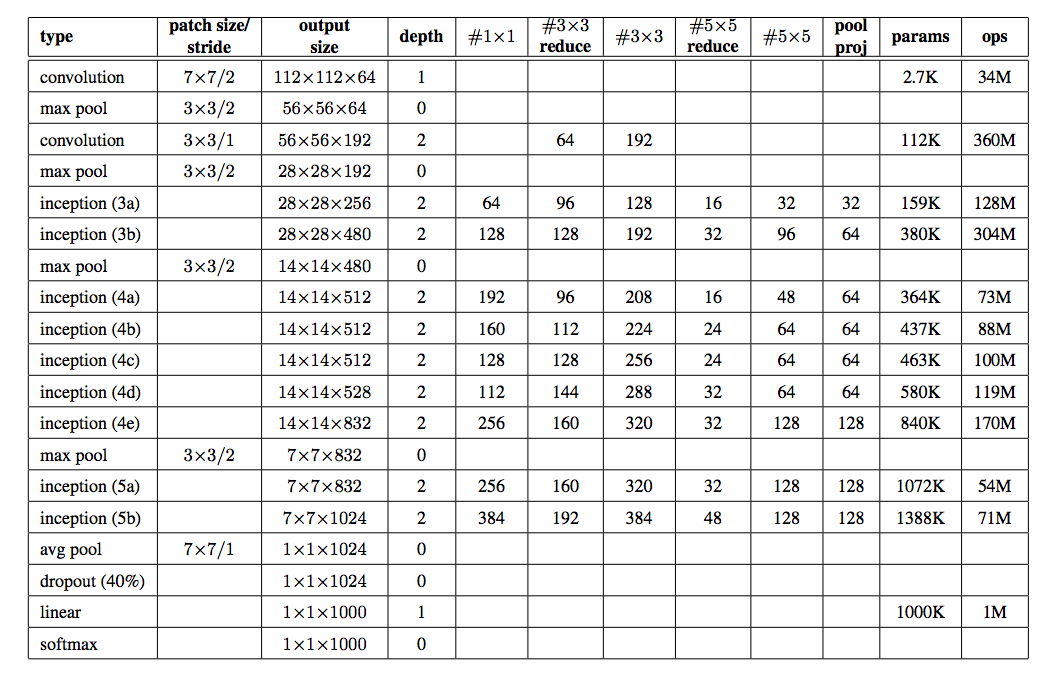

In [5]:
Image(filename='../pic/googlenet-parameters.png')

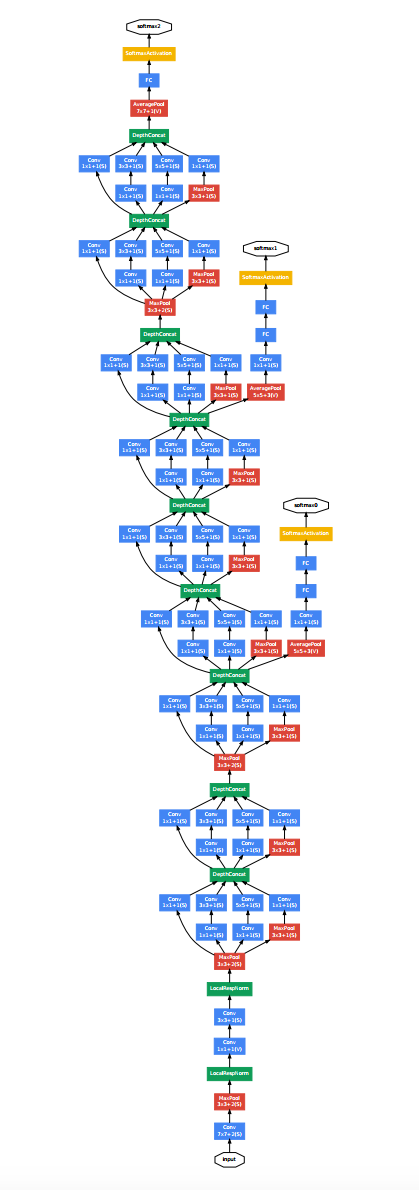

In [6]:
Image(filename='../pic/googlenet-model.png')

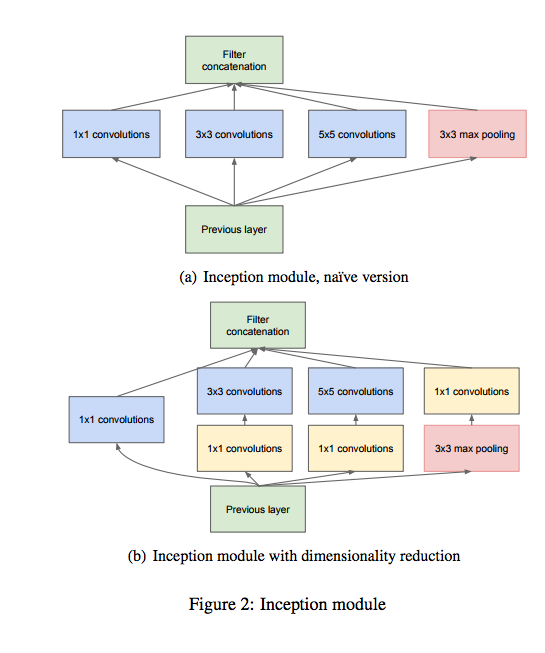

In [7]:
Image(filename='../pic/googlenet-module.png')

# Define Functions

In [ ]:
pred=tf.nn.softmax(end_layer)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= pred , labels=y_) , name='cost')
train=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost,name='train')
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32), name='accuracy')

# softmax : 결과값을 각 class 에 해당하는 확률값을로 리턴
# softmax_cross_entropy_with_logits : 실제 정답인 onehot vector 와 예측값 pred 를 차이를 cross_entropy 로 계산
# tf.train.GradientDescentOptimizer : cost 가 최소와 되도록 weight를 조정하는 함수
# accuracy : 실제 값과 예측값의 일치률

# Training

In [ ]:
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

batch_iteration = 100    
training_epochs = 2000

train_cost_list = []
test_cost_list = []
train_acc_list = []
test_acc_list = []

# Tensorflow 학습을 위한 session 정의
# saver : 학습한 weight 와 graph 를 저장

# sess.run 을 통해 함수를 실행 , feed_dict 는 placeholder 에 들어갈 값

for epoch in range(training_epochs):
    
    train_avg_cost = 0.
    train_avg_acc = 0.
    test_avg_cost = 0.
    test_avg_acc = 0.
    
    for batch in range(batch_iteration) :
        batch_xs , batch_ys = next_batch(train_imgs , train_labs , 20)
        
        sess.run(train, feed_dict={x_:batch_xs , y_ : batch_ys})
        train_avg_cost += sess.run(cost, feed_dict={x_:batch_xs , y_ : batch_ys})
        train_avg_acc += sess.run(accuracy, feed_dict={x_:batch_xs , y_ : batch_ys})
        
    train_avg_cost = train_avg_cost / batch_iteration
    train_avg_acc = train_avg_acc / batch_iteration
    
#     test_avg_cost = sess.run(cost, feed_dict={x_: test_imgs, y_: test_labs})
#     test_avg_acc = sess.run(accuracy, feed_dict={x_: test_imgs, y_: test_labs})
    
    
    print "##################################"
    print ("Epoch: %03d/%03d train cost: %.4f" % (epoch, training_epochs, train_avg_cost))
    print ("Epoch: %03d/%03d train acc: %.4f" % (epoch, training_epochs, train_avg_acc))
#     print ("Epoch: %03d/%03d test cost: %.4f" % (epoch, training_epochs, test_avg_cost))
#     print ("Epoch: %03d/%03d test acc: %.4f" % (epoch, training_epochs, test_avg_acc))    
    
#     train_cost_list.append(train_avg_cost)
#     test_cost_list.append(test_avg_cost)
#     train_acc_list.append(train_avg_acc)
#     test_acc_list.append(test_avg_acc)
   
    
    
# saver.save(sess, "model/cifar_deep_convolution.ckpt")

# with open('cost_acc/cifar_deep_convolution_train_cost', 'wb') as fp:
#     pickle.dump(train_cost_list, fp)
# with open('cost_acc/cifar_deep_convolution_test_cost', 'wb') as fp:
#     pickle.dump(test_cost_list, fp)
# with open('cost_acc/cifar_deep_convolution_train_acc', 'wb') as fp:
#     pickle.dump(train_acc_list, fp)
# with open('cost_acc/cifar_deep_convolution_test_acc', 'wb') as fp:
#     pickle.dump(test_acc_list, fp)

##################################
Epoch: 000/2000 train cost: 6.9078
Epoch: 000/2000 train acc: 0.0005
